# Optimizing convolutional neural networks with scikit-optimize

The goal of this example is to train a classifier that can label handwritten digits from the MNIST dataset.

First, we define a convolutional neural network using the TensorFlow framework.

We then use `scikit-optimize` to find a set of hyperparameters that gives good results.

To simplify the construction and training of the neural network, we can use the `learn` and `layers` contrib modules from TensorFlow.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.gaussian_process import GaussianProcessRegressor
import tensorflow as tf
from tensorflow.contrib import learn
from tensorflow.contrib import layers

We import the MNIST dataset and take a look at one of the labeled images

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
> Digit is labeled as 3


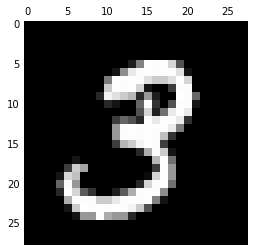

In [2]:
digits = learn.datasets.mnist.load_mnist()
X_train, y_train = digits.train.images, digits.train.labels
X_test, y_test = digits.test.images, digits.test.labels

print('> Digit is labeled as {}'.format(y_train[1]))
plt.matshow(np.reshape(X_train[1, :], (28, 28)), cmap='gray')

Now, we define the convolutional neural network.
We make sure to construct, train, and evaluate it inside a single function, which we will pass as an objective function to `sciki-optimize`.

In [3]:
def tensorflow_objective(params):
    learning_rate, batch_size, num_layers, num_channels, kernel_size, dense_size, dropout = params
    print('Params: {}'.format(params))
    # Used to decide whether we should use dropout
    is_training = True
    
    # This function defines the custom TensorFlow model
    def conv_model(X, y):
        # Reshape into batches of 28x28 pixel images with 1 channel
        X = tf.reshape(X, [-1, 28, 28, 1])
        # Build multiple convolutional layers with max-pooling
        for _ in range(num_layers):
            k = kernel_size
            X = layers.conv2d(X, num_channels, [k, k], activation_fn=tf.nn.relu)
            X = tf.nn.max_pool(X, [1, k, k, 1], [1, k, k, 1], padding='SAME')

        # Add a large dense layer
        X = layers.flatten(X)
        X = layers.fully_connected(X, int(dense_size), activation_fn=tf.nn.relu)
        # Add dropout layer
        if is_training:
            X = tf.nn.dropout(X, dropout)
        # Add readout layer
        X = layers.fully_connected(X, 10, activation_fn=tf.nn.softmax)
        # Calculate loss
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(y* tf.log(X), reduction_indices=1))
        return X, cross_entropy

    # The tf.contrib.learn package provides a scikit-learn
    # compatible API for training TensorFlow models,
    # which makes it easy to train and evaluate the model.
    clf = learn.TensorFlowEstimator(
        model_fn=conv_model,
        n_classes=10,
        steps=5000,
        learning_rate=learning_rate,
        batch_size=batch_size,
        optimizer='Adagrad',
    )

    clf.fit(X_train, y_train)
    is_training = False
    score =  metrics.accuracy_score(clf.predict(X_test), y_test)
    print('Accuracy: {}'.format(score))
    return -score

# Disable warnings
import logging
logger = logging.getLogger('tensorflow')
logger.setLevel(logging.ERROR)

Now that the model is defined, we can use `scikit-optimize` to find good hyperparameters.

In [ ]:
from skopt import gp_minimize

reg = GaussianProcessRegressor(alpha=1e-1)
space  = [
          (10**-3, 1, 'log-uniform'),  # learning_rate
          (16, 128),                   # batch_size
          (1, 3),                      # num_layers
          (16, 64),                    # num_channels
          (2, 4),                      # kernel_size
          (256, 1024),                 # dense_size
          (0.6, 1.0, 'uniform'),       # dropout probability
         ]

x0 = [0.1, 32, 2, 32, 2, 512, 0.9]
res_gp = gp_minimize(tensorflow_objective, space, x0=x0, n_calls=20, random_state=0)

'Best accuracy: {}'.format(-res_gp.fun)

Params: [0.1, 32, 2, 32, 2, 512, 0.9]
Accuracy: 0.9761
Params: [0.044303752452182647, 118, 2, 35, 2, 806, 0.77481278151973654]
Accuracy: 0.9769
Params: [0.13981961408994042, 55, 1, 35, 4, 744, 0.87905247837090594]
